# Required Tools

In [1]:
# !pip install mne scipy numpy pandas scikit-learn matplotlib tqdm

# B. Imports & config

In [2]:
import os
import glob
import numpy as np
import pandas as pd
import mne
from scipy import signal
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings

# For reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Ignoring all warnings
warnings.filterwarnings('ignore')

# Config
DATA_DIR = "data"        # folder containing subject folders or EDF files
SUBJECT = "chb01"                   # optional, for iterating per-subject
EDF_GLOB = os.path.join(DATA_DIR, "*.edf")   # or glob on subject subfolder
OUTPUT_FEATURE_CSV = "data/chb_features.csv"

# C. Utility: load EDF

In [3]:
def load_edf(edf_path, preload=True, verbose=False):
    """
    Loads an EDF file using mne.io.read_raw_edf
    Returns Raw object
    """
    raw = mne.io.read_raw_edf(edf_path, preload=preload, verbose=verbose)
    # CHB-MIT has annotation channel sometimes; drop if present
    # Keep only EEG channels
    picks = mne.pick_types(raw.info, eeg=True, meg=False, eog=False)
    if len(picks) == 0:
        raise RuntimeError("No EEG channels found in EDF: " + edf_path)
    raw.pick(picks)
    return raw

## Example:

In [4]:
raw = load_edf("data/chb01_01.edf")
raw.info, raw.ch_names[:10]

(<Info | 8 non-empty values
  bads: []
  ch_names: FP1-F7, F7-T7, T7-P7, P7-O1, FP1-F3, F3-C3, C3-P3, P3-O1, ...
  chs: 23 EEG
  custom_ref_applied: False
  highpass: 0.0 Hz
  lowpass: 128.0 Hz
  meas_date: 2076-11-06 11:42:54 UTC
  nchan: 23
  projs: []
  sfreq: 256.0 Hz
  subject_info: <subject_info | his_id: Surrogate>
 >,
 ['FP1-F7',
  'F7-T7',
  'T7-P7',
  'P7-O1',
  'FP1-F3',
  'F3-C3',
  'C3-P3',
  'P3-O1',
  'FP2-F4',
  'F4-C4'])

# D. Filters - design & apply

In [5]:
def design_notch(freq, sfreq, quality=30.0):
    """IIR notch via iirnotch (scipy). freq in Hz (e.g., 60)."""
    w0 = freq / (sfreq / 2.)
    b, a = signal.iirnotch(w0, quality)
    return b, a

In [6]:
def design_bandpass_fir(lowcut, highcut, sfreq, numtaps=801, window='hamming'):
    """
    FIR bandpass design with window method. numtaps should be odd for linear phase.
    Returns filter coefficients b (FIR) and a=1.
    """
    nyq = 0.5 * sfreq
    low = lowcut / nyq
    high = highcut / nyq
    b = signal.firwin(numtaps, [low, high], pass_zero=False, window=window)
    a = np.array([1.0])
    return b, a

In [7]:
def design_bandpass_iir(lowcut, highcut, sfreq, order=4, btype='band'):
    """Butterworth IIR design (bi-directional recommended for zero-phase)."""
    nyq = 0.5 * sfreq
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype=btype)
    return b, a

In [8]:
def apply_filter_raw(raw, b, a, method='sos', use_sos=True):
    """
    Apply filter to an mne Raw object data (zero-phase by filtfilt).
    If b,a are IIR or FIR, use filtfilt on numpy data.
    """
    data = raw.get_data()  # shape (n_channels, n_samples)
    sfreq = int(raw.info['sfreq'])
    #filtfilt for zero-phase
    try:
        filtered = signal.filtfilt(b, a, data, axis=1, padtype='odd', padlen=3*(max(len(a), len(b))))
    except Exception as e:
        # fallback using lfilter (non-zero-phase)
        filtered = signal.lfilter(b, a, data, axis=1)
    new_raw = mne.io.RawArray(filtered, raw.info, verbose=False)
    return new_raw

## Example usage:

In [9]:
raw = load_edf('data/chb01_01.edf')
b_notch, a_notch = design_notch(60, raw.info['sfreq'])
print("Notch Filter Parameters: ")
print(f"b: {b_notch}, \na: {a_notch}")
raw_notched = apply_filter_raw(raw, b_notch, a_notch)

b_bp, a_bp = design_bandpass_fir(0.5, 70, raw.info['sfreq'], numtaps=801)
raw_bp = apply_filter_raw(raw_notched, b_bp, a_bp)
print("Bandpass Filter Parameters: ")
print(f"b: {b_bp[:4]}, \na: {a_bp}")

Notch Filter Parameters: 
b: [ 0.97603957 -0.19133722  0.97603957], 
a: [ 1.         -0.19133722  0.95207915]
Bandpass Filter Parameters: 
b: [1.07434505e-04 1.00760813e-04 6.61639283e-06 4.17781736e-05], 
a: [1.]


# E. Segmentation (epoching) & normalization

In [10]:
def segment_raw(raw, epoch_length_sec=10.0, overlap=0.0):
    """
    Splits raw data into fixed-length epochs.
    Returns list of numpy arrays shape (n_channels, epoch_samples)
    """
    sfreq = raw.info['sfreq']
    epoch_samples = int(epoch_length_sec * sfreq)
    step = int(epoch_samples * (1 - overlap))
    data = raw.get_data()
    total_samples = data.shape[1]
    epochs = []
    starts = range(0, total_samples - epoch_samples + 1, step)
    for s in starts:
        ep = data[:, s:s+epoch_samples].copy()
        epochs.append(ep)
    return np.array(epochs)  # shape (n_epochs, n_channels, n_samples)

In [11]:
def normalize_epoch(epoch, method='zscore'):
    """
    epoch: (n_channels, n_samples)
    method: 'zscore' or 'minmax' or 'per_channel_mean'
    """
    if method == 'zscore':
        mean = epoch.mean(axis=1, keepdims=True)
        std = epoch.std(axis=1, keepdims=True)
        std[std == 0] = 1.0
        return (epoch - mean) / std
    elif method == 'minmax':
        mn = epoch.min(axis=1, keepdims=True)
        mx = epoch.max(axis=1, keepdims=True)
        denom = (mx - mn)
        denom[denom == 0] = 1
        return (epoch - mn) / denom
    else:
        return epoch - epoch.mean(axis=1, keepdims=True)

## Example:

In [12]:
epochs = segment_raw(raw_bp, epoch_length_sec=10.0, overlap=0.5)
norm_epoch = normalize_epoch(epochs[0], 'zscore')

print(f"epochs shape: {epochs.shape}")
print(f"normamized epoch shape: {norm_epoch.shape}")

epochs shape: (719, 23, 2560)
normamized epoch shape: (23, 2560)


# F. DSP demonstrations - correlation, convolution (smoothing), FFT

In [13]:
def channel_correlation_matrix(epoch):
    """Compute Pearson correlation matrix between channels for an epoch."""
    return np.corrcoef(epoch)

In [14]:
def smooth_epoch(epoch, kernel_len=5):
    """Convolve each channel with a moving average kernel (simple smoothing)."""
    kernel = np.ones(kernel_len) / kernel_len
    smoothed = signal.convolve(epoch, kernel[None, :], mode='same')
    return smoothed

In [15]:
def compute_fft(epoch, sfreq):
    """
    Compute FFT magnitudes per channel for an epoch.
    Returns freqs and mags shape (n_channels, n_freqs)
    """
    n = epoch.shape[1]
    freqs = np.fft.rfftfreq(n, 1.0/sfreq)
    fft_vals = np.fft.rfft(epoch, axis=1)
    mags = np.abs(fft_vals) / n
    return freqs, mags

In [16]:
def plot_time_and_spectrum(epoch, sfreq, channel_idx=0, title=None):
    t = np.arange(epoch.shape[1]) / sfreq
    freqs, mags = compute_fft(epoch[[channel_idx]], sfreq)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(t, epoch[channel_idx])
    plt.xlabel("Time (s)"); plt.title("Time domain" + (": "+title if title else ""))
    plt.subplot(1,2,2)
    plt.semilogy(freqs, mags[channel_idx])
    plt.xlabel("Frequency (Hz)"); plt.title("Magnitude spectrum")
    plt.tight_layout()
    plt.show()

## Example usage:

In [17]:
corr = channel_correlation_matrix(norm_epoch)
sm = smooth_epoch(norm_epoch, kernel_len=11)

# G. Spectral analysis helpers (Welch, band powers, spectral entropy)

In [18]:
def bandpower_psd(epoch_channel, sfreq, band, nperseg=None):
    """Compute band power using Welch PSD (absolute power)."""
    if nperseg is None:
        nperseg = min(256, epoch_channel.size)
    freqs, psd = signal.welch(epoch_channel, fs=sfreq, nperseg=nperseg)
    freq_res = freqs[1] - freqs[0]
    low, high = band
    idx_band = np.logical_and(freqs >= low, freqs <= high)
    power = np.trapz(psd[idx_band], freqs[idx_band])
    return power

In [19]:
def compute_all_band_powers(epoch, sfreq, bands=None):
    """
    epoch: (n_channels, n_samples)
    bands: dict of band_name -> (low, high)
    Returns dict band_name -> array(n_channels,)
    """
    if bands is None:
        bands = {
            'delta': (0.5, 4),
            'theta': (4, 8),
            'alpha': (8, 13),
            'beta' : (13, 30),
            'gamma': (30, 70)
        }
    res = {}
    for name, band in bands.items():
        res[name] = np.array([bandpower_psd(epoch[ch], sfreq, band) for ch in range(epoch.shape[0])])
    return res

In [20]:
def spectral_entropy(epoch_channel, sfreq, nperseg=None):
    """Spectral entropy via normalized PSD (Shannon entropy)."""
    if nperseg is None:
        nperseg = min(256, epoch_channel.size)
    freqs, psd = signal.welch(epoch_channel, fs=sfreq, nperseg=nperseg)
    psd_norm = psd / np.sum(psd)
    psd_norm = psd_norm + 1e-12  # avoid log(0)
    ent = -np.sum(psd_norm * np.log2(psd_norm))
    return ent

# H. Feature extraction for one epoch

In [21]:
def extract_features_for_epoch(epoch, sfreq):
    """
    epoch: (n_channels, n_samples)
    Returns a dictionary of aggregated features for the epoch (flattened across channels).
    Strategy: for each channel compute bandpowers, energy, mean, var, skew, kurtosis, spectral entropy.
    Also compute pairwise correlation stats (mean, std of upper-triangular entries).
    """
    feats = {}
    n_ch = epoch.shape[0]
    # band powers per channel
    bands = {
        'delta': (0.5, 4),
        'theta': (4, 8),
        'alpha': (8, 13),
        'beta' : (13, 30),
        'gamma': (30, 70)
    }
    bp = compute_all_band_powers(epoch, sfreq, bands=bands)
    for band_name, arr in bp.items():
        feats[f'{band_name}_mean'] = arr.mean()
        feats[f'{band_name}_std']  = arr.std()
        feats[f'{band_name}_max']  = arr.max()
        feats[f'{band_name}_median'] = np.median(arr)

    # Time-domain stats per channel aggregated
    energies = np.sum(epoch**2, axis=1)
    feats['energy_mean'] = energies.mean()
    feats['energy_std']  = energies.std()
    feats['signal_mean'] = epoch.mean()
    feats['signal_std']  = epoch.std()
    feats['signal_skew'] = skew(epoch.reshape(-1))
    feats['signal_kurtosis'] = kurtosis(epoch.reshape(-1))

    # spectral entropy aggregated
    entropies = np.array([spectral_entropy(epoch[ch], sfreq) for ch in range(n_ch)])
    feats['spec_ent_mean'] = entropies.mean()
    feats['spec_ent_std']  = entropies.std()

    # Correlation matrix summary
    corr = channel_correlation_matrix(epoch)
    # take upper triangle without diagonal
    iu = np.triu_indices_from(corr, k=1)
    if len(iu[0]) > 0:
        corr_vals = corr[iu]
        feats['corr_mean'] = np.nanmean(corr_vals)
        feats['corr_std']  = np.nanstd(corr_vals)
        feats['corr_max']  = np.nanmax(corr_vals)
    else:
        feats['corr_mean'] = 0
        feats['corr_std'] = 0
        feats['corr_max'] = 0

    # Additional: relative bandpower ratios (e.g., alpha/beta)
    total_power_per_ch = np.sum([bp[b][...] for b in bp], axis=0) + 1e-12
    alpha = bp['alpha']
    beta  = bp['beta']
    feats['alpha_beta_ratio_mean'] = np.mean(alpha / (beta + 1e-12))

    return feats

## Example:

In [22]:
feats = extract_features_for_epoch(norm_epoch, raw.info['sfreq'])
pd.Series(feats)

delta_mean               4.399167e-01
delta_std                1.228783e-01
delta_max                6.807148e-01
delta_median             4.258677e-01
theta_mean               1.349422e-01
theta_std                4.845031e-02
theta_max                2.298486e-01
theta_median             1.324952e-01
alpha_mean               4.656732e-02
alpha_std                2.951320e-02
alpha_max                1.199470e-01
alpha_median             4.241738e-02
beta_mean                8.853269e-02
beta_std                 4.415512e-02
beta_max                 1.917555e-01
beta_median              7.905160e-02
gamma_mean               8.281448e-02
gamma_std                7.025587e-02
gamma_max                2.544092e-01
gamma_median             5.518275e-02
energy_mean              2.560000e+03
energy_std               3.547891e-13
signal_mean             -3.861645e-18
signal_std               1.000000e+00
signal_skew              2.563691e-01
signal_kurtosis          2.943603e+00
spec_ent_mea

# I. Build feature matrix from a file (with optional label annotations)

In [23]:
def build_feature_matrix_from_edf(edf_path, epoch_length_sec=10.0, overlap=0.5,
                                  apply_notch=True, notch_freq=60.0,
                                  bp_filter=('fir', 0.5, 70), normalize_method='zscore',
                                  label=None, verbose=False):
    """
    Processes one EDF file end-to-end and returns a DataFrame with per-epoch features and labels.
    bp_filter: ('fir'|'iir', lowcut, highcut)
    label: optional (e.g., 1 for seizure, 0 for non-seizure) - to build a label mapping externally using annotations
    """
    raw = load_edf(edf_path, preload=True)
    sfreq = raw.info['sfreq']

    # notch
    if apply_notch:
        b_n, a_n = design_notch(notch_freq, sfreq, quality=30.0)
        raw = apply_filter_raw(raw, b_n, a_n)

    # bandpass
    ftype, lowcut, highcut = bp_filter
    if ftype == 'fir':
        b_bp, a_bp = design_bandpass_fir(lowcut, highcut, sfreq, numtaps=801)
    else:
        b_bp, a_bp = design_bandpass_iir(lowcut, highcut, sfreq, order=4)
    raw = apply_filter_raw(raw, b_bp, a_bp)

    # segmentation
    epochs = segment_raw(raw, epoch_length_sec=epoch_length_sec, overlap=overlap)

    features_list = []
    for epoch in epochs:
        epoch_norm = normalize_epoch(epoch, method=normalize_method)
        feats = extract_features_for_epoch(epoch_norm, sfreq)
        feats['edf_file'] = os.path.basename(edf_path)
        # optionally adding epoch start time (samples) or any annotation-based label
        feats['label'] = label
        features_list.append(feats)

    df = pd.DataFrame(features_list)
    return df

## Example (no labels):

In [24]:
df = build_feature_matrix_from_edf("data/chb01_01.edf", epoch_length_sec=10, overlap=0.5)
df.head()

,delta_mean,delta_std,delta_max,delta_median,theta_mean,theta_std,theta_max,theta_median,alpha_mean,alpha_std,...,signal_skew,signal_kurtosis,spec_ent_mean,spec_ent_std,corr_mean,corr_std,corr_max,alpha_beta_ratio_mean,edf_file,label
0,0.439917,0.122878,0.680715,0.425868,0.134942,0.048450,0.229849,0.132495,0.046567,0.029513,...,0.256369,2.943603,3.894096,0.604832,0.094079,0.319205,1.0,0.590751,chb01_01.edf,None
1,0.491996,0.147472,0.753315,0.489125,0.157016,0.071678,0.355560,0.139707,0.052553,0.036122,...,0.163628,3.781029,3.952233,0.678081,0.089288,0.290171,1.0,0.548683,chb01_01.edf,None
2,0.375810,0.082527,0.485999,0.389008,0.155521,0.067377,0.320863,0.145871,0.055865,0.031640,...,0.083959,3.887230,4.371788,0.646738,0.092746,0.248896,1.0,0.484118,chb01_01.edf,None
3,0.328070,0.089442,0.475458,0.338504,0.164152,0.065626,0.293830,0.164945,0.056487,0.021148,...,0.441731,3.293229,4.486092,0.552320,0.147066,0.260859,1.0,0.531328,chb01_01.edf,None
4,0.467772,0.085527,0.657703,0.458547,0.173338,0.052196,0.284436,0.168564,0.054683,0.029469,...,0.309528,2.573853,3.889251,0.465952,0.148925,0.287578,1.0,0.694480,chb01_01.edf,None


# J. Batch process EDF files & save features

## Example: process all EDF files found in EDF_GLOB and save features

In [25]:
edf_files = sorted(glob.glob(EDF_GLOB))
print(f"Found {len(edf_files)} EDF files. Processing a sample or all...")

Found 2 EDF files. Processing a sample or all...


### For demo, we process first N files or all; adjust N or provide list of seizure/non-seizure labels externally.

In [26]:
N = len(edf_files)  # smaller number for quick run, e.g., 3
all_dfs = []
for edf in tqdm(edf_files[:N]):
    # NOTE: For CHB-MIT, seizure annotations are in separate files; here we set label=None.
    # Later to parse the .seizure files or the dataset readme to get epoch labels.
    try:
        df_temp = build_feature_matrix_from_edf(edf, epoch_length_sec=10.0, overlap=0.5,
                                               apply_notch=True, notch_freq=60.0,
                                               bp_filter=('fir', 0.5, 70),
                                               normalize_method='zscore')
        all_dfs.append(df_temp)
    except Exception as e:
        print("Error processing", edf, ":", e)

if len(all_dfs) > 0:
    features_df = pd.concat(all_dfs, ignore_index=True)
    features_df.to_csv(OUTPUT_FEATURE_CSV, index=False)
    print("Saved features to", OUTPUT_FEATURE_CSV)
else:
    features_df = pd.DataFrame()
    print("No features created.")

100%|██████████| 2/2 [04:03<00:00, 121.67s/it]

Saved features to data/chb_features.csv


- Combine features from seizure and non-seizure EDFs
- Assuming features already extracted into 'features_df' or similar variable
- If not, make sure earlier cells create 'features_df' containing at least ['edf_file', <feature columns>]

In [27]:
# Drop any completely empty columns (safe cleanup)
features_df = features_df.dropna(axis=1, how='all')

# --- Add label column manually ---
# Label seizure vs. non-seizure based on filename
features_df['label'] = features_df['edf_file'].apply(
    lambda f: 1 if 'seizure' in f.lower() or '03' in f.lower() else 0
)

# Now separate features (X) and labels (y)
# Keep only numerical feature columns
exclude_cols = ['edf_file', 'label']
X = features_df.drop(columns=[col for col in exclude_cols if col in features_df.columns], errors='ignore')
y = features_df['label']

print("Feature matrix shape:", X.shape)
print("Labels shape:", y.shape)
print("Class balance (0=non-seizure, 1=seizure):")
print(y.value_counts())

Feature matrix shape: (1438, 32)
Labels shape: (1438,)
Class balance (0=non-seizure, 1=seizure):
label
0    719
1    719
Name: count, dtype: int64


# K. Visualizations

In [28]:
# Plotting example spectrogram for first epoch of first file
def plot_spectrogram(epoch_channel, sfreq, channel_name='ch0', nperseg=256, seizure=False):
    f, t, Sxx = signal.spectrogram(epoch_channel, fs=sfreq, nperseg=nperseg)
    plt.figure(figsize=(8,4))
    plt.pcolormesh(t, f, 10*np.log10(Sxx + 1e-12), shading='gouraud')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title(f"Spectrogram: {channel_name} - {"seizure" if seizure else ""}")
    plt.colorbar(label='Power (dB)')
    plt.ylim(0, 70)
    plt.tight_layout()
    plt.show()

## Fig. 1: Spectrogram for Chb01_01.edf (non-seizure).

256.0


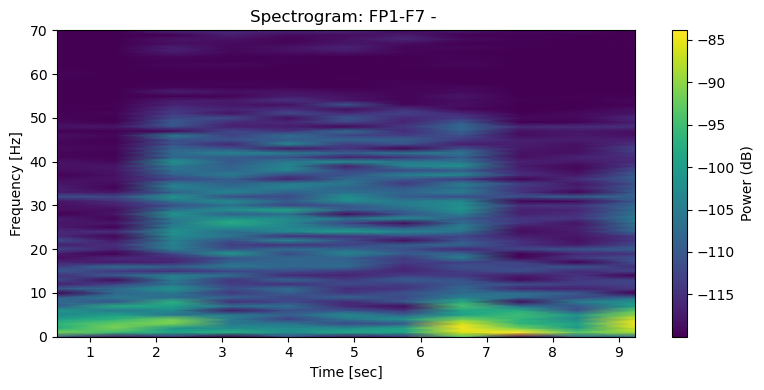

In [29]:
raw_example = load_edf(edf_files[0])
print(raw_example.info['sfreq'])
raw_example = apply_filter_raw(raw_example, *design_notch(60, raw_example.info['sfreq']))
epochs = segment_raw(raw_example, epoch_length_sec=10.0, overlap=0.0)
plot_spectrogram(epochs[0][0], raw_example.info['sfreq'], channel_name=raw_example.ch_names[0])

## Fig. 2: Spectrogram for Chb01_03.edf (seizure).

256.0


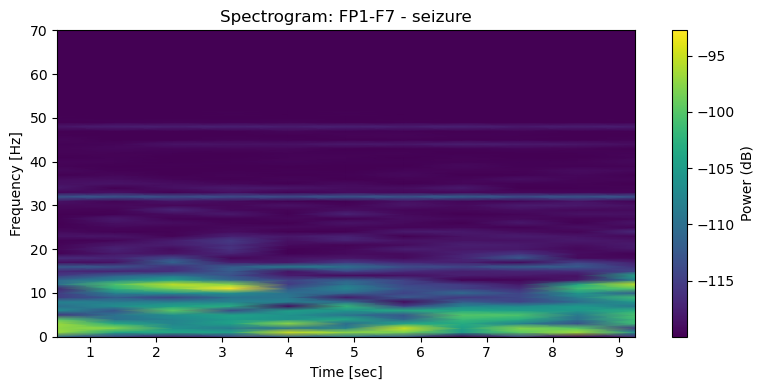

In [30]:
raw_example = load_edf(edf_files[1])
print(raw_example.info['sfreq'])
raw_example = apply_filter_raw(raw_example, *design_notch(60, raw_example.info['sfreq']))
epochs = segment_raw(raw_example, epoch_length_sec=10.0, overlap=0.0)
plot_spectrogram(epochs[0][0], raw_example.info['sfreq'], channel_name=raw_example.ch_names[0], seizure=True)

## Fig. 3: Raw and filtered Signals and their Spectrums for  Chb01_01.edf .

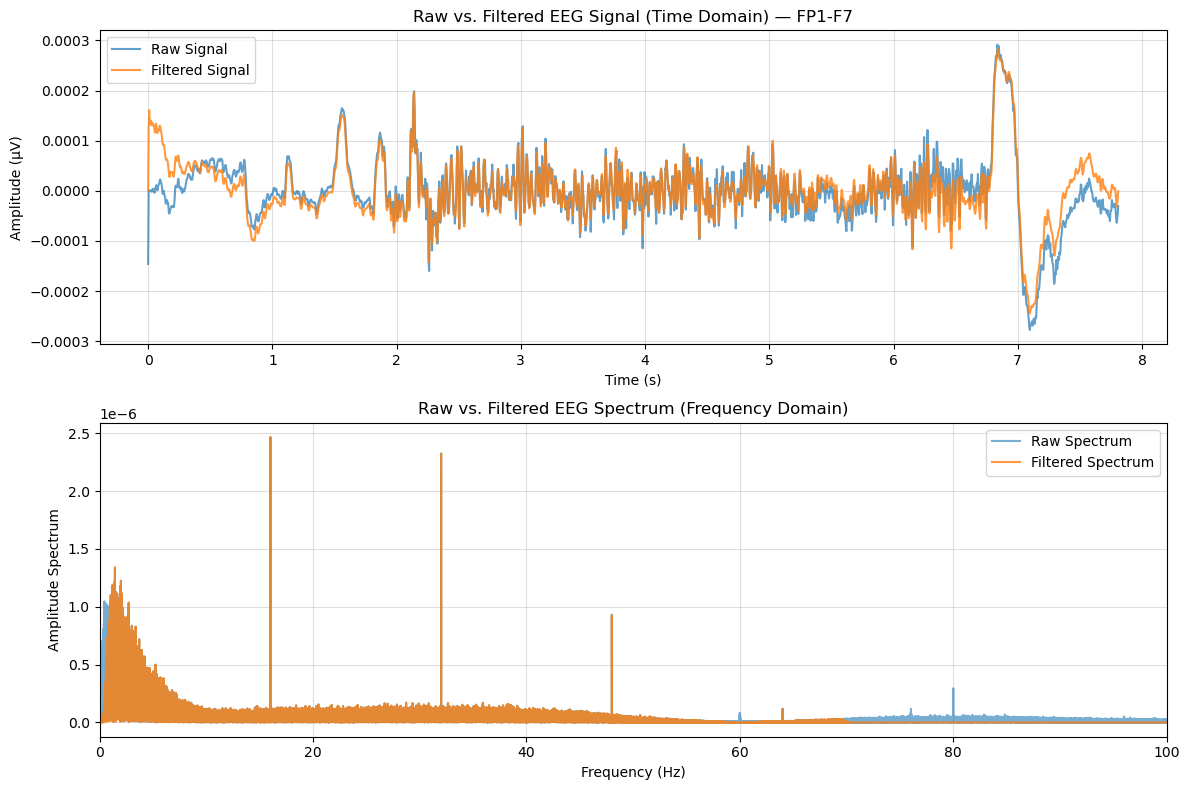

In [31]:
edf_path = edf_files[0]
raw_original = load_edf(edf_path)
sfreq = raw_original.info['sfreq']

# Applying notch and bandpass filtering
b_notch, a_notch = design_notch(60, sfreq)
raw_notched = apply_filter_raw(raw_original, b_notch, a_notch)
b_bp, a_bp = design_bandpass_fir(0.5, 70, sfreq, numtaps=801)
raw_filtered = apply_filter_raw(raw_notched, b_bp, a_bp)

# Picking one electrode and extract data
channel = raw_filtered.ch_names[0]  # e.g., 'FP1-F7'
raw_data, times = raw_original[channel, :]
filt_data, _ = raw_filtered[channel, :]

# Computing FFT for frequency-domain comparison
def compute_fft(signal, fs):
    N = len(signal)
    freqs = np.fft.rfftfreq(N, d=1/fs)
    spectrum = np.abs(np.fft.rfft(signal)) / N
    return freqs, spectrum

freqs_raw, spec_raw = compute_fft(raw_data[0], sfreq)
freqs_filt, spec_filt = compute_fft(filt_data[0], sfreq)

# Plotting time and frequency domain together
plt.figure(figsize=(12, 8))

# --- Time Domain ---
plt.subplot(2, 1, 1)
plt.plot(times[:2000], raw_data[0][:2000], label='Raw Signal', alpha=0.7)
plt.plot(times[:2000], filt_data[0][:2000], label='Filtered Signal', alpha=0.8)
plt.title(f"Raw vs. Filtered EEG Signal (Time Domain) — {channel}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.legend()
plt.grid(alpha=0.4)

# --- Frequency Domain ---
plt.subplot(2, 1, 2)
plt.plot(freqs_raw, spec_raw, label='Raw Spectrum', alpha=0.6)
plt.plot(freqs_filt, spec_filt, label='Filtered Spectrum', alpha=0.8)
plt.xlim(0, 100)  # Focus on EEG band range
plt.title("Raw vs. Filtered EEG Spectrum (Frequency Domain)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude Spectrum")
plt.legend()
plt.grid(alpha=0.4)

plt.tight_layout()
plt.show()

## Fig. 4: Average Band Power Across EEG Frequency Bands for  Chb01_01.edf .

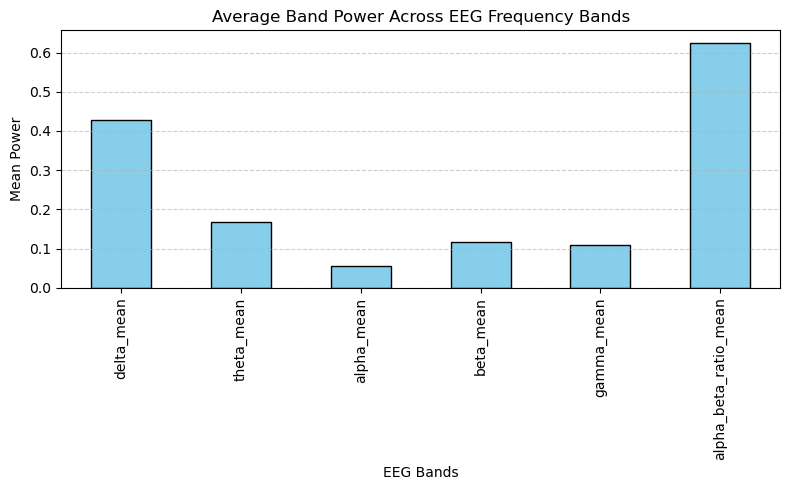

In [32]:
band_features = [col for col in df.columns if col.startswith(('delta', 'theta', 'alpha', 'beta', 'gamma')) and col.endswith('_mean')]
if band_features:
    plt.figure(figsize=(8, 5))
    df[band_features].mean().plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title("Average Band Power Across EEG Frequency Bands")
    plt.ylabel("Mean Power")
    plt.xlabel("EEG Bands")
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
else:
    print("No band power features found.")

## Fig. 5: Distribution of Statistical Time-Domain Features for  Chb01_01.edf .

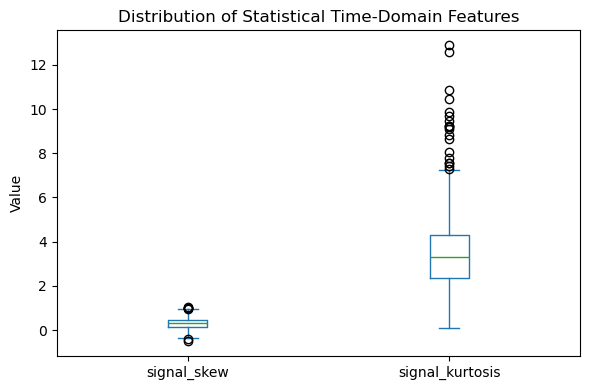

In [33]:
stat_features = ['signal_skew', 'signal_kurtosis']
available = [f for f in stat_features if f in df.columns]

if available:
    df[available].plot(kind='box', figsize=(6, 4))
    plt.title("Distribution of Statistical Time-Domain Features")
    plt.ylabel("Value")
    plt.tight_layout()
    plt.show()
else:
    print("No statistical time-domain features found.")

Fig. 6: Spectral Entropy vs. Delta Band Power for  Chb01_01.edf .

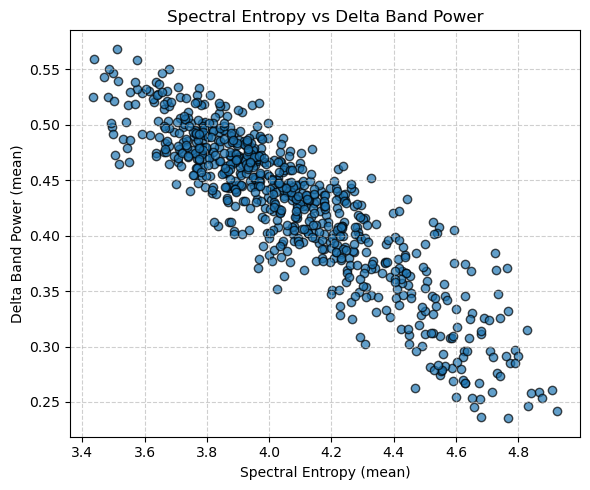

In [34]:
if {'spec_ent_mean', 'delta_mean'}.issubset(df.columns):
    plt.figure(figsize=(6, 5))
    plt.scatter(df['spec_ent_mean'], df['delta_mean'], alpha=0.7, edgecolor='k')
    plt.xlabel("Spectral Entropy (mean)")
    plt.ylabel("Delta Band Power (mean)")
    plt.title("Spectral Entropy vs Delta Band Power")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
else:
    print("Required columns not found for entropy-power correlation.")

## Fig. 7: Distribution of Inter-Channel Correlation Metrics for  Chb01_01.edf .

<Figure size 700x400 with 0 Axes>

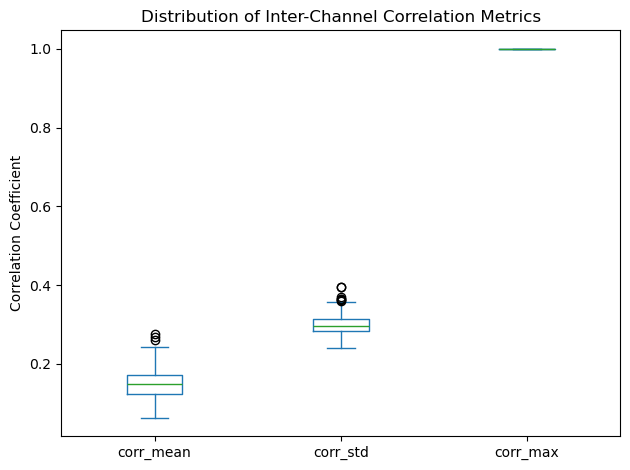

In [35]:
corr_cols = [c for c in ['corr_mean', 'corr_std', 'corr_max'] if c in df.columns]
if corr_cols:
    plt.figure(figsize=(7, 4))
    df[corr_cols].plot(kind='box')
    plt.title("Distribution of Inter-Channel Correlation Metrics")
    plt.ylabel("Correlation Coefficient")
    plt.tight_layout()
    plt.show()
else:
    print("Correlation feature columns not found.")